## Data Loading

In [139]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from helpers import *
%matplotlib inline

Firstly, let's create our data-frame from our source data. Additionally, we'll transform the `Score_home` and `Score_away` columns into our target variable such that:
$$
y = \cases{-1 \\ 
            0 \\
            1 }
$$
using the helper function `score_to_win()`

In [2]:
DATA_SRC = '../Data/PL_site_2006_2018/masterdata.csv'
df = pd.read_csv(DATA_SRC)

# create win/lose label
df['target'] = df[['Score_home', 'Score_away']].apply(score_to_win, axis = 1)
df.sort_values('MatchID', inplace = True)
df.head()

,MatchID,Home_team,Away_team,Score_home,Score_away,Possession_home,Possession_away,Shots_on_target_home,Shots_on_target_away,Shots_home,...,year,Expenditures_home,Arrivals_home,Income_home,Departures_home,Expenditures_away,Arrivals_away,Income_away,Departures_away,target
373,5567,Arsenal,Aston Villa,1,1,72.9,27.1,7,3,24,...,2007,17.10,18,14.85,21,28.16,17,2.08,18,0
379,5568,Bolton,Spurs,2,0,37.8,62.2,4,2,13,...,2007,19.38,16,4.39,16,69.54,23,44.06,23,1
374,5569,Everton,Watford,2,1,47.0,53.0,2,7,8,...,2007,20.41,11,2.85,16,11.97,29,15.39,23,1
375,5570,Newcastle,Wigan,2,1,55.3,44.7,5,4,8,...,2007,36.34,8,12.74,14,29.24,23,27.73,25,1
376,5571,Portsmouth,Blackburn,3,0,44.3,55.7,11,3,21,...,2007,10.37,28,1.43,32,18.84,21,19.28,25,1


### Feature Extraction
Now, we must drop several variables from the above table in order to fit our model. We'll create `df_wo` to pass in. This leaves us with 24 avaiable features.

In [3]:
df_wo = df.drop(columns = ['target', 'MatchID', 'Home_team', 'Away_team', 'Score_home', 'Score_away', 'year'])
print(len(df_wo.columns))
list(df_wo)

32


['Possession_home',
 'Possession_away',
 'Shots_on_target_home',
 'Shots_on_target_away',
 'Shots_home',
 'Shots_away',
 'Touches_home',
 'Touches_away',
 'Passes_home',
 'Passes_away',
 'Tackles_home',
 'Tackles_away',
 'Clearances_home',
 'Clearances_away',
 'Corners_home',
 'Corners_away',
 'Offsides_home',
 'Offsides_away',
 'Yellow_cards_home',
 'Yellow_cards_away',
 'Fouls_conceded_home',
 'Fouls_conceded_away',
 'Red_cards_home',
 'Red_cards_away',
 'Expenditures_home',
 'Arrivals_home',
 'Income_home',
 'Departures_home',
 'Expenditures_away',
 'Arrivals_away',
 'Income_away',
 'Departures_away']

## EDA
### Correlation

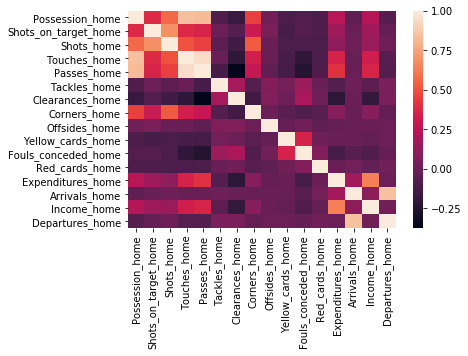

In [4]:
import seaborn as sns
home_features = [ f for f in list(df_wo) if '_home' in f ]
corr = df_wo[home_features].corr()
_ = sns.heatmap(corr)

What can we tell about the pairplots?

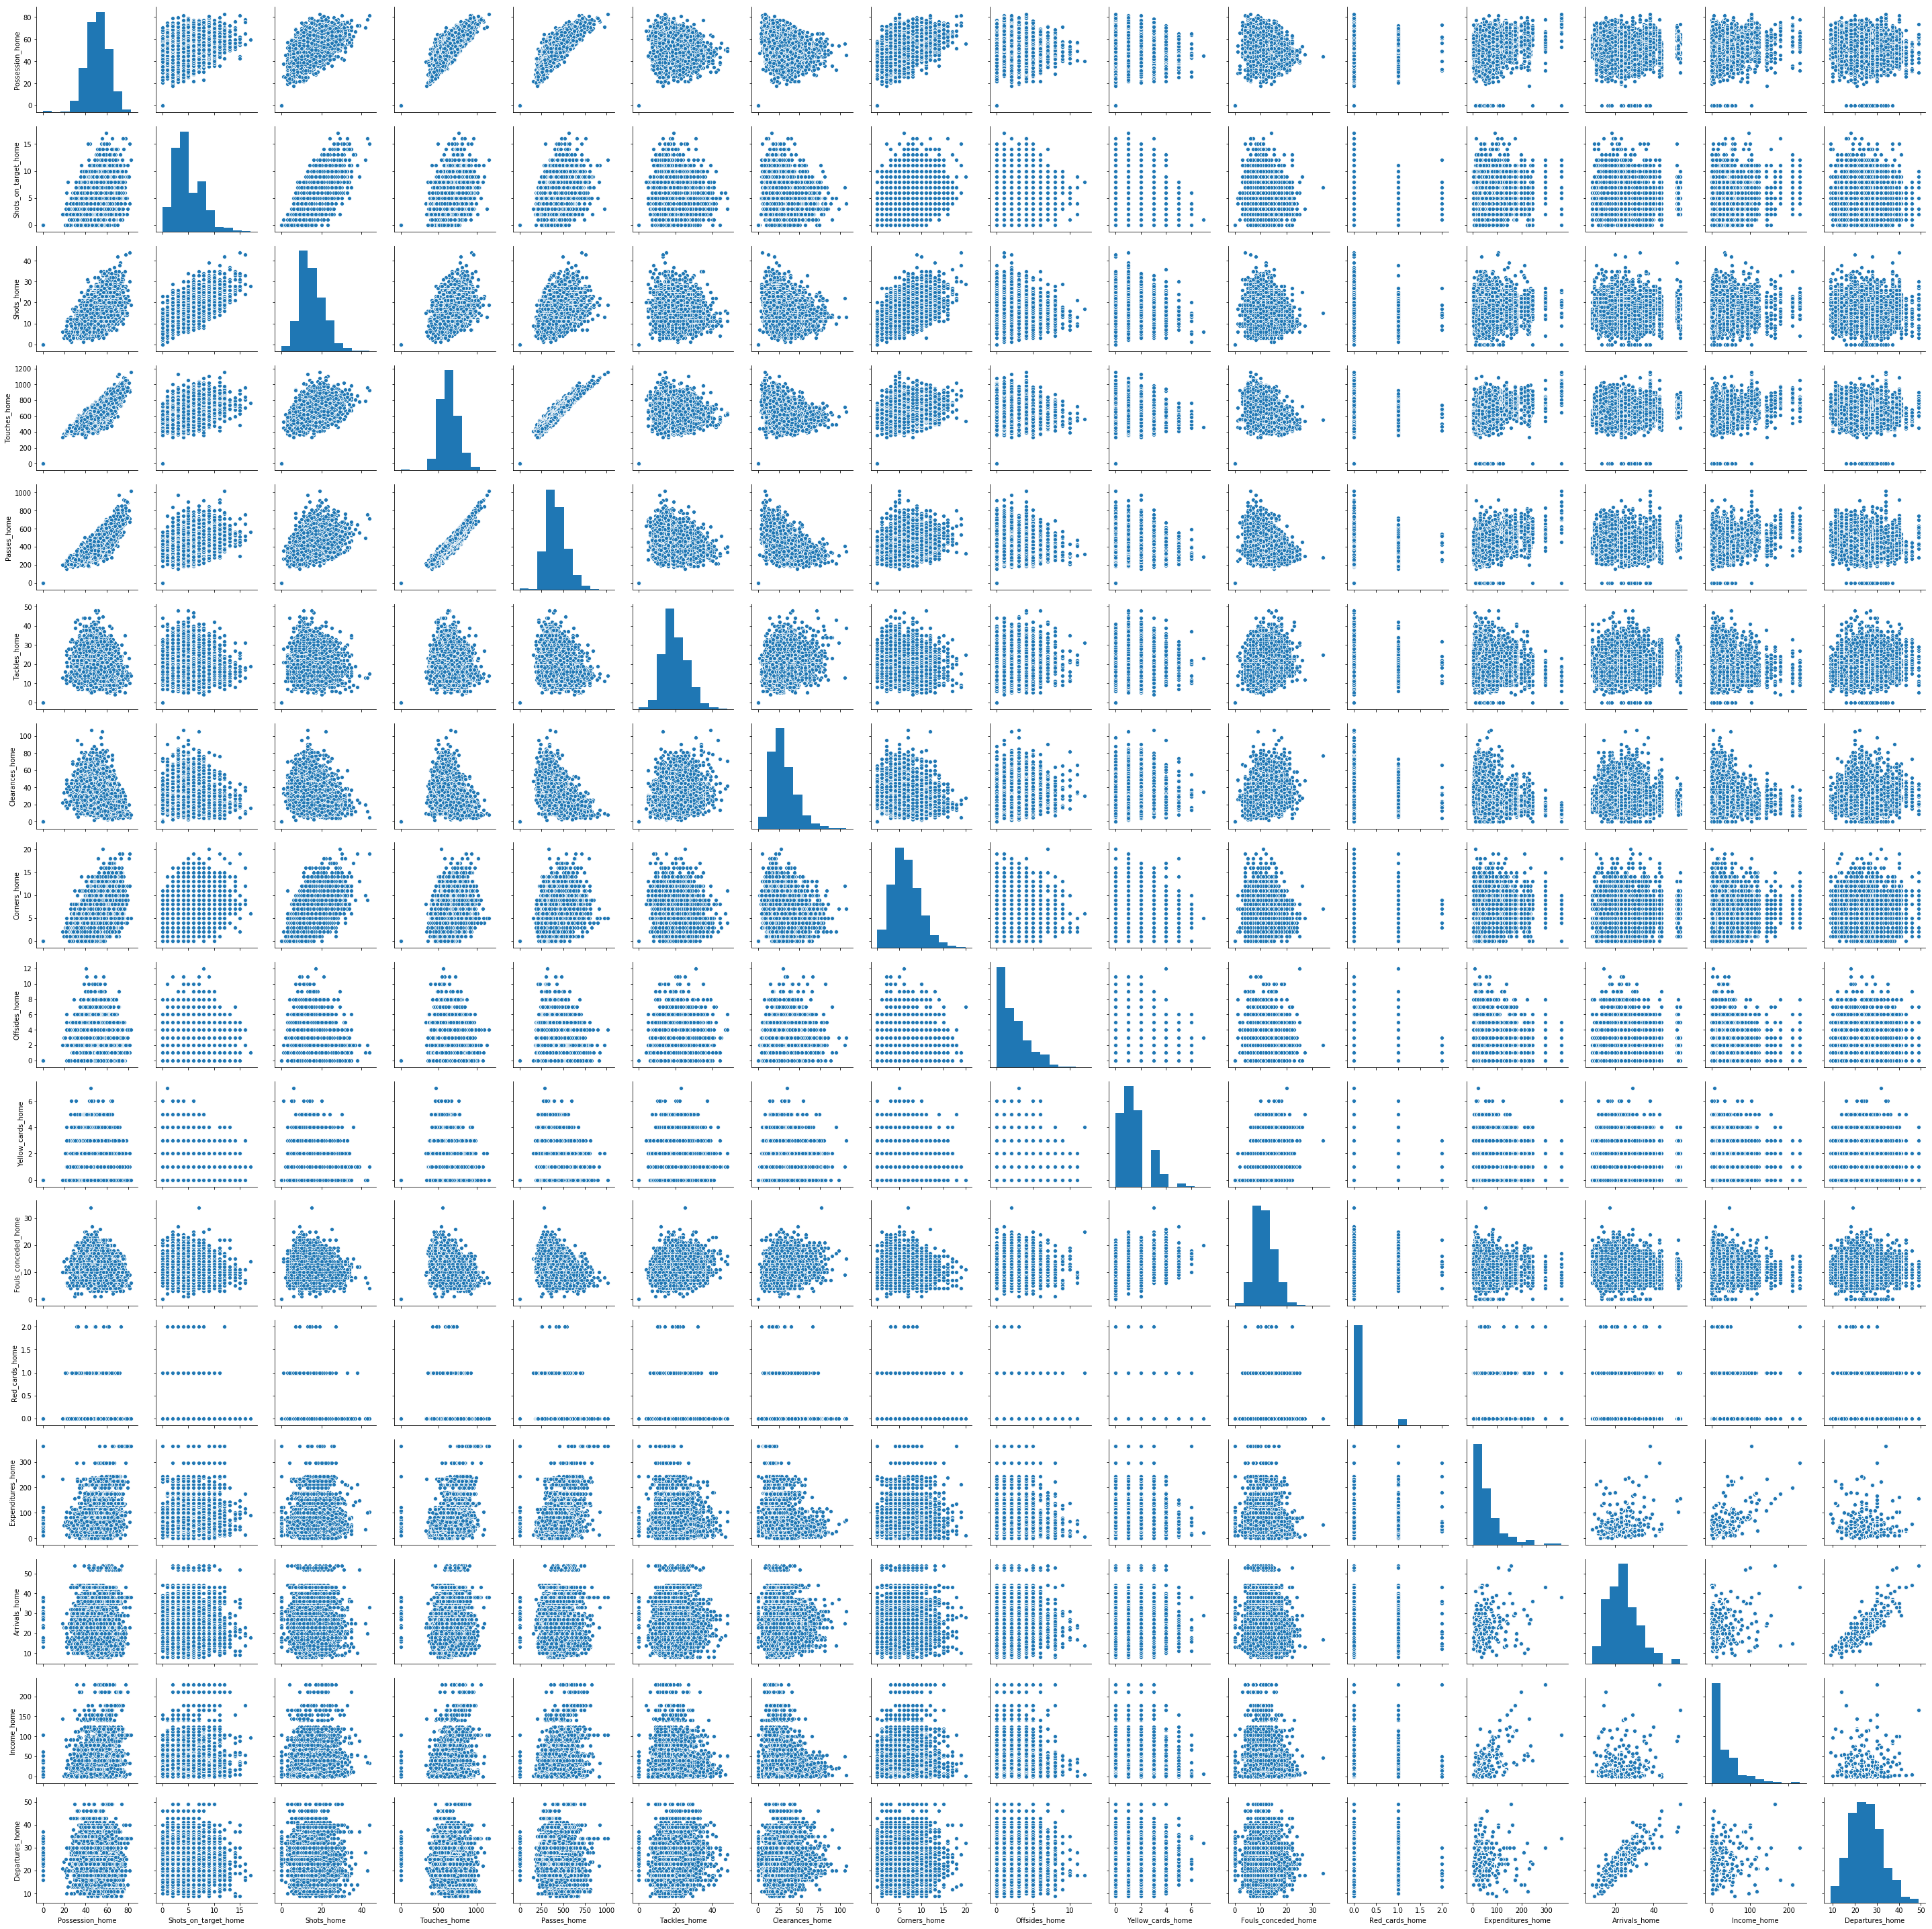

In [5]:
_ = sns.pairplot(df_wo[home_features])

### Variance Inflation
It is likely the case that several of the above variables are collinear. Now, in many models this might not have an effect as the coefficients for one variable will be high while the other will just be nullified. However, based on our correlation analysis it is clear some variables are capturing the same information. For example, possession is highly correlated with touches and passes. This isn't surprising, if a team possesses the ball for long stretches they are likely moving the ball around. 

We can use `statsmodels.stats.outliers_influence.variance_inflation_factor` to perform this analysis in Python.

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vifs = []
for i, feature in enumerate(list(df_wo)):
    vif_tup = (feature, variance_inflation_factor(df_wo.values, i))
    vifs.append( vif_tup )
vifs

[('Possession_home', 431.17404355511786),
 ('Possession_away', 430.16643323876826),
 ('Shots_on_target_home', 8.883291072896263),
 ('Shots_on_target_away', 7.44151459164484),
 ('Shots_home', 22.520041585871265),
 ('Shots_away', 18.837524258895257),
 ('Touches_home', 1679.5076507203844),
 ('Touches_away', 1632.1707715500168),
 ('Passes_home', 866.7726380734396),
 ('Passes_away', 832.1405275890884),
 ('Tackles_home', 14.49891835822139),
 ('Tackles_away', 14.866586844166966),
 ('Clearances_home', 12.486285927241783),
 ('Clearances_away', 14.771723609087307),
 ('Corners_home', 7.930314726148676),
 ('Corners_away', 6.517295988030291),
 ('Offsides_home', 2.770202203225566),
 ('Offsides_away', 2.6078753284393934),
 ('Yellow_cards_home', 3.0287265948844517),
 ('Yellow_cards_away', 3.5656105737383568),
 ('Fouls_conceded_home', 14.665480991067916),
 ('Fouls_conceded_away', 14.919611355366138),
 ('Red_cards_home', 1.1170833111416631),
 ('Red_cards_away', 1.1463853596258216),
 ('Expenditures_home'

These scores are really high. Typically, we'd like to ignore variables with VIF > 5. Clearly, we have a lot of shared information contained in this dataset.

## Feature Engineering
### Form
Often, in the sport, commentators and analysts point to a team's form (essentially the recent performance) as being somewhat important in their performance in an individual game. The thinking goes: if this team has played well, they will continue to play well. It is not dissimilar to the concept of momentum, in a way. Here, we'll use an exponential weighting scheme of previous results (where the importance of each game decays as we go further back in time).

In [7]:
scores = df[['MatchID', 'Home_team', 'Away_team', 'Score_home', 'Score_away']].values
gd = gd_vectors(scores)

away_form_linear = []
home_form_linear = []
away_form_exp = []
home_form_exp = []
for game in scores:
    id, home_team, away_team, _, _ = game
    away_form_exp.append( exponential_momentum(id, away_team, gd, alpha = .65) )
    home_form_exp.append( exponential_momentum(id, home_team, gd, alpha = .65) )
    away_form_linear.append( linear_momentum(id, away_team, gd) )
    home_form_linear.append( linear_momentum(id, home_team, gd) )


df_form = df.copy()
df_form['away_form_exp'] = pd.Series(away_form_exp)
df_form['home_form_exp'] = pd.Series(home_form_exp)
list(df_form)

['MatchID',
 'Home_team',
 'Away_team',
 'Score_home',
 'Score_away',
 'Possession_home',
 'Possession_away',
 'Shots_on_target_home',
 'Shots_on_target_away',
 'Shots_home',
 'Shots_away',
 'Touches_home',
 'Touches_away',
 'Passes_home',
 'Passes_away',
 'Tackles_home',
 'Tackles_away',
 'Clearances_home',
 'Clearances_away',
 'Corners_home',
 'Corners_away',
 'Offsides_home',
 'Offsides_away',
 'Yellow_cards_home',
 'Yellow_cards_away',
 'Fouls_conceded_home',
 'Fouls_conceded_away',
 'Red_cards_home',
 'Red_cards_away',
 'year',
 'Expenditures_home',
 'Arrivals_home',
 'Income_home',
 'Departures_home',
 'Expenditures_away',
 'Arrivals_away',
 'Income_away',
 'Departures_away',
 'target',
 'away_form_exp',
 'home_form_exp']

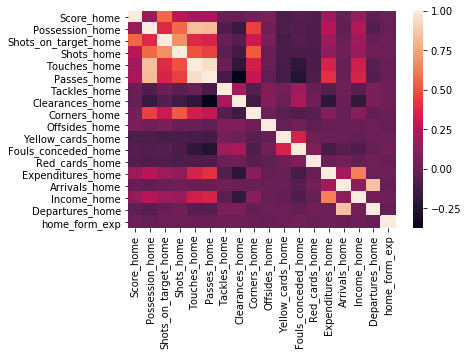

In [8]:
home_features = [ f for f in list(df_form) if 'home' in f ]
corr = df_form[home_features].corr()
_ = sns.heatmap(corr)

Unfortunately, given this result it doesn't appear that a team's form is highly correlated with its recent form. 

## Modeling

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [10]:
clfs = [LogisticRegression(), RandomForestClassifier(), GradientBoostingClassifier(),
        KNeighborsClassifier()]

In [11]:
df_form.drop(columns = ['target', 'MatchID', 'Home_team', 'Away_team', 
                                 'Score_home', 'Score_away', 'year'], inplace = True)
X = df_wo.values
X_form = df_form.values
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)
X_train_form, X_test_form, y_train_form, y_test_form = train_test_split(X_form, y, test_size = .2, random_state = 42)

In [12]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)
X_train_form_std = sc.fit_transform(X_train_form)
X_test_form_std = sc.transform(X_test_form)

In [13]:
for clf in clfs:
    clf.fit(X_train, y_train)
    print(type(clf))
    print("score = ", clf.score(X_test, y_test), "\n")

<class 'sklearn.linear_model.logistic.LogisticRegression'>
score =  0.6524122807017544 

<class 'sklearn.ensemble.forest.RandomForestClassifier'>
score =  0.555921052631579 

<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
score =  0.6337719298245614 

<class 'sklearn.neighbors.classification.KNeighborsClassifier'>
score =  0.47478070175438597 



In [14]:
#With scaled variables
for clf in clfs:
    clf.fit(X_train_std, y_train)
    print(type(clf))
    print("score = ", clf.score(X_test_std, y_test), "\n")

<class 'sklearn.linear_model.logistic.LogisticRegression'>
score =  0.6513157894736842 

<class 'sklearn.ensemble.forest.RandomForestClassifier'>
score =  0.5734649122807017 

<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
score =  0.6326754385964912 

<class 'sklearn.neighbors.classification.KNeighborsClassifier'>
score =  0.5208333333333334 



In [15]:
for clf in clfs:
    clf.fit(X_train_form, y_train_form)
    print(type(clf))
    print("score = ", clf.score(X_test_form, y_test_form), "\n")

<class 'sklearn.linear_model.logistic.LogisticRegression'>
score =  0.6491228070175439 

<class 'sklearn.ensemble.forest.RandomForestClassifier'>
score =  0.5471491228070176 

<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
score =  0.6381578947368421 

<class 'sklearn.neighbors.classification.KNeighborsClassifier'>
score =  0.4780701754385965 



In [16]:
#With scaled variables
for clf in clfs:
    clf.fit(X_train_form_std, y_train_form)
    print(type(clf))
    print("score = ", clf.score(X_test_form_std, y_test_form), "\n")

<class 'sklearn.linear_model.logistic.LogisticRegression'>
score =  0.6535087719298246 

<class 'sklearn.ensemble.forest.RandomForestClassifier'>
score =  0.5844298245614035 

<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
score =  0.6403508771929824 

<class 'sklearn.neighbors.classification.KNeighborsClassifier'>
score =  0.5361842105263158 



Again, the inclusion of a form variable doesn't appear to make a material difference in our modeling procedure.

### Coefficient Investigation
Logistic Regression in particular provides a nice idea of the importance of our variables. Roughly, the larger coefficients suggest a higher importance of that feature. By inspection, we can potential use domain knowledge to drop collinear variables while keeping the best one. I.e. pick between `Touches` and `Passes`.

In [17]:
for i, feature in enumerate(list(df_form)):
    print(feature, ": ", clfs[0].coef_[:,i])

Possession_home :  [ 1.46685211  0.32783203 -1.67803501]
Possession_away :  [-1.59882084 -0.33546592  1.80029026]
Shots_on_target_home :  [-0.82475677 -0.47264256  1.11921143]
Shots_on_target_away :  [ 0.9580185  -0.19110054 -0.69265384]
Shots_home :  [ 0.14497567  0.07417009 -0.19843088]
Shots_away :  [-0.15622931  0.01325057  0.11096368]
Touches_home :  [-0.70343919  0.49468001  0.16256425]
Touches_away :  [ 0.81985073 -0.0518745  -0.52652521]
Passes_home :  [-1.04071359 -0.9713738   1.87622939]
Passes_away :  [ 1.11676979  0.27092106 -1.45803665]
Tackles_home :  [-0.04883463  0.02620391  0.01698064]
Tackles_away :  [ 0.14443763 -0.08504439 -0.03112994]
Clearances_home :  [-0.58012977 -0.13870185  0.60800326]
Clearances_away :  [ 0.48926653  0.17471796 -0.71839296]
Corners_home :  [-0.0146166   0.01455158  0.03133489]
Corners_away :  [ 0.03203055  0.06210273 -0.08769304]
Offsides_home :  [-0.08408601 -0.02975609  0.09136751]
Offsides_away :  [ 0.0227071   0.01581962 -0.04542279]
Yell

### Reduction of Feature Set with Domain knowledge 
What if we drop some variables that are pretty collinear, or even proxies for one another. Perhaps then our models would perform better.

Based on the above, it would appear dropping shots in lieu of shots on target would be beneficial. This is perhaps unsurprising given we could take lots of bad shots, so in a sense we care about the quality of a shot, not just whether it happened. Similarly, possession seems to be more important than touches and passes. It stands to reason that most of the informational content of the touches and passes of a team are contained with the amount of possession they had during the game. 

In [18]:
features_to_drop = ['Shots_home', 'Shots_away', 'Touches_home', 
                                 'Touches_away', 'Possession_home', 'Possession_away',
                                 'Tackles_home', 'Tackles_away', 'Arrivals_home', 'Arrivals_away',
                                 'Departures_home', 'Departures_away', 'Corners_home', 'Corners_away',
                                 'Red_cards_home', 'Red_cards_away', 'Yellow_cards_home', 'Yellow_cards_away']
df_sub = df_form.drop(columns = features_to_drop)
print(list(df_sub))

['Shots_on_target_home', 'Shots_on_target_away', 'Passes_home', 'Passes_away', 'Clearances_home', 'Clearances_away', 'Offsides_home', 'Offsides_away', 'Fouls_conceded_home', 'Fouls_conceded_away', 'Expenditures_home', 'Income_home', 'Expenditures_away', 'Income_away', 'away_form_exp', 'home_form_exp']


Now, let's re-fit and see if we get any performance gains.

#### Results

In [19]:
X_sub = df_sub.values
X_train, X_test, y_train, y_test = train_test_split(X_sub, y, test_size = .2, random_state = 42)

for clf in clfs:
    clf.fit(X_train, y_train)
    print(type(clf))
    print("score = ", clf.score(X_test, y_test), "\n")

<class 'sklearn.linear_model.logistic.LogisticRegression'>
score =  0.6392543859649122 

<class 'sklearn.ensemble.forest.RandomForestClassifier'>
score =  0.581140350877193 

<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
score =  0.6480263157894737 

<class 'sklearn.neighbors.classification.KNeighborsClassifier'>
score =  0.4440789473684211 



Seems pretty sticky. 

In [20]:
for i, feature in enumerate(list(df_sub)):
    print(feature, ": ", clfs[0].coef_[:,i])

Shots_on_target_home :  [-0.28776    -0.15576186  0.37466749]
Shots_on_target_away :  [ 0.39187507 -0.07009177 -0.29882118]
Passes_home :  [ 3.95712859e-04 -6.41247525e-04  4.27952840e-05]
Passes_away :  [ 0.00071791 -0.00119974  0.00038194]
Clearances_home :  [-0.05170206 -0.00609411  0.04672775]
Clearances_away :  [ 0.04273818  0.01536758 -0.05819091]
Offsides_home :  [-0.06042658 -0.01465479  0.06172464]
Offsides_away :  [ 0.03577922  0.00283113 -0.03316276]
Fouls_conceded_home :  [ 0.00893148  0.01131566 -0.01777893]
Fouls_conceded_away :  [-0.0335454   0.02152197  0.0026745 ]
Expenditures_home :  [-0.00525391 -0.00019591  0.00337067]
Income_home :  [-0.00056444 -0.00029798  0.00151245]
Expenditures_away :  [ 0.00341883 -0.00040176 -0.00309859]
Income_away :  [ 0.00229727  0.00043624 -0.00222711]
away_form_exp :  [-0.0524064  -0.00600862  0.04965472]
home_form_exp :  [ 0.03291854 -0.01756596  0.00355901]


Our gains are pretty minimal here.

In [21]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(df_sub.values)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = .2, random_state = 42)

for clf in clfs:
    clf.fit(X_train, y_train)
    print(type(clf))
    print("score = ", clf.score(X_test, y_test), "\n")

<class 'sklearn.linear_model.logistic.LogisticRegression'>
score =  0.6392543859649122 

<class 'sklearn.ensemble.forest.RandomForestClassifier'>
score =  0.5997807017543859 

<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
score =  0.6469298245614035 

<class 'sklearn.neighbors.classification.KNeighborsClassifier'>
score =  0.543859649122807 



### Assessing feature importance with random forests

In [22]:
forest = RandomForestClassifier(n_estimators=500,random_state=42)
forest.fit(X_train_form, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [23]:
features = df_form.columns
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]
indices
for f in range(X_train_form.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,features[indices[f]], importances[indices[f]]))

 1) Shots_on_target_home           0.067018
 2) Clearances_away                0.060890
 3) Shots_on_target_away           0.057999
 4) Clearances_home                0.046923
 5) Expenditures_away              0.035892
 6) Expenditures_home              0.035195
 7) Passes_away                    0.034805
 8) Passes_home                    0.033784
 9) Touches_away                   0.033538
10) away_form_exp                  0.032924
11) Income_away                    0.032830
12) home_form_exp                  0.032207
13) Income_home                    0.031685
14) Touches_home                   0.031667
15) Shots_away                     0.029152
16) Shots_home                     0.028812
17) Possession_home                0.028223
18) Possession_away                0.028175
19) Tackles_away                   0.026489
20) Tackles_home                   0.026467
21) Arrivals_away                  0.025923
22) Departures_home                0.025422
23) Departures_away             

### Feature selection with Sequential Backward Selection (SBS)

In [24]:
from SBS import *

In [28]:
lr = LogisticRegression()
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()
knn = KNeighborsClassifier()

clf_labels = ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'KNN']

all_clf = [lr, rf, gb, knn]

for label, clf in zip(clf_labels, all_clf):
    print(label, clf)

Logistic Regression LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Random Forest RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Gradient Boosting GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              m

In [30]:
k_feat = {key: None for key in clf_labels}
sbs = {key: None for key in clf_labels}

sbs

{'Logistic Regression': None,
 'Random Forest': None,
 'Gradient Boosting': None,
 'KNN': None}

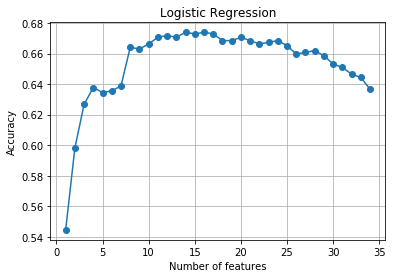

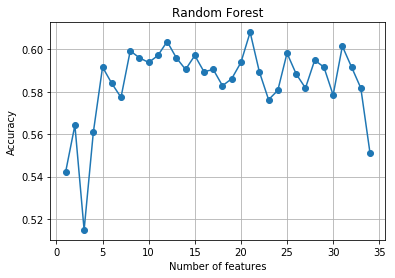

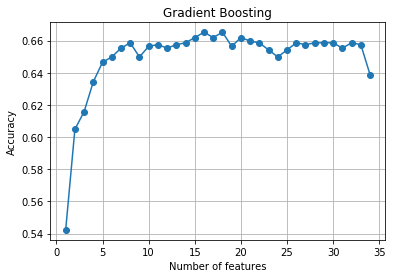

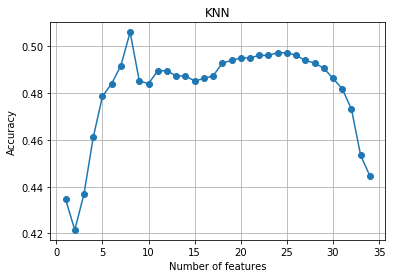

In [31]:
#Note: this step will take 10 minutes to run!
import matplotlib.pyplot as plt

for label, clf in zip(clf_labels, all_clf):
    sbs[label] = SBS(clf,k_features=1)
    sbs[label].fit(X_train_form,y_train)
    k_feat[label] = [len(k) for k in sbs[label].subsets_]
    plt.plot(k_feat[label], sbs[label].scores_, marker='o')
    #plt.ylim([0.3, 1.02])
    plt.title(label)
    plt.ylabel('Accuracy')
    plt.xlabel('Number of features')
    plt.grid()
    plt.show()

#### Results  
With Logistic regression, the optimum number of features is 14  
With Random Forest, the optimum number of features is 21  
With Gradient Boosting, the optimum number of features is 16  
With KNN, the optimum number of features is 8  

In [39]:
lr_features = list(sbs['Logistic Regression'].subsets_[20])
for idx, i in enumerate(lr_features):
    print(idx,features[i]) 

0 Possession_home
1 Possession_away
2 Shots_on_target_home
3 Shots_on_target_away
4 Shots_home
5 Passes_home
6 Passes_away
7 Tackles_away
8 Clearances_home
9 Clearances_away
10 Fouls_conceded_away
11 Arrivals_home
12 Expenditures_away
13 Departures_away


In [40]:
rf_features = list(sbs['Random Forest'].subsets_[13])
for idx, i in enumerate(rf_features):
    print(idx,features[i]) 

0 Possession_home
1 Shots_on_target_home
2 Shots_on_target_away
3 Shots_home
4 Shots_away
5 Touches_home
6 Passes_home
7 Tackles_home
8 Tackles_away
9 Clearances_home
10 Clearances_away
11 Corners_home
12 Offsides_home
13 Offsides_away
14 Yellow_cards_home
15 Red_cards_home
16 Income_home
17 Departures_home
18 Arrivals_away
19 Income_away
20 away_form_exp


In [41]:
gb_features = list(sbs['Gradient Boosting'].subsets_[18])
for idx, i in enumerate(gb_features):
    print(idx,features[i]) 

0 Possession_home
1 Shots_on_target_home
2 Shots_on_target_away
3 Shots_home
4 Touches_home
5 Passes_away
6 Tackles_home
7 Clearances_home
8 Clearances_away
9 Corners_home
10 Offsides_home
11 Yellow_cards_home
12 Fouls_conceded_away
13 Departures_home
14 Income_away
15 Departures_away


In [42]:
knn_features = list(sbs['KNN'].subsets_[26])
for idx, i in enumerate(knn_features):
    print(idx,features[i]) 

0 Touches_away
1 Tackles_home
2 Clearances_home
3 Clearances_away
4 Arrivals_home
5 Income_home
6 Expenditures_away
7 Arrivals_away


#### Checking the performance of the selected features
It seems like using the selected features can only slighyly improve test accuracy for our classifiers

In [50]:
for clf in clfs:
    clf.fit(X_train_form, y_train_form)
    print(type(clf))
    print("score = ", clf.score(X_test_form, y_test_form), "\n")

<class 'sklearn.linear_model.logistic.LogisticRegression'>
score =  0.6491228070175439 

<class 'sklearn.ensemble.forest.RandomForestClassifier'>
score =  0.5603070175438597 

<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
score =  0.6381578947368421 

<class 'sklearn.neighbors.classification.KNeighborsClassifier'>
score =  0.4780701754385965 



In [57]:
lr.fit(X_train_form[:, lr_features], y_train_form)
print('Train accuracy:', lr.score(X_train_form[:, lr_features], y_train_form))
print('Test accuracy:', lr.score(X_test_form[:, lr_features], y_test_form))

Train accuracy: 0.634742041712404
Test accuracy: 0.6491228070175439


In [58]:
rf.fit(X_train_form[:, rf_features], y_train_form)
print('Train accuracy:', rf.score(X_train_form[:, rf_features], y_train_form))
print('Test accuracy:', rf.score(X_test_form[:, rf_features], y_test_form))

Train accuracy: 0.9887486278814489
Test accuracy: 0.5745614035087719


In [59]:
gb.fit(X_train_form[:, gb_features], y_train_form)
print('Train accuracy:', gb.score(X_train_form[:, gb_features], y_train_form))
print('Test accuracy:', gb.score(X_test_form[:, gb_features], y_test_form))

Train accuracy: 0.7280461031833151
Test accuracy: 0.6282894736842105


In [60]:
knn.fit(X_train_form[:, knn_features], y_train_form)
print('Train accuracy:', knn.score(X_train_form[:, knn_features], y_train_form))
print('Test accuracy:', knn.score(X_test_form[:, knn_features], y_test_form))

Train accuracy: 0.6501097694840834
Test accuracy: 0.4923245614035088


### Feature extraction with PCA

In [62]:
from PlotDecisionRegions import *
from sklearn.decomposition import PCA

In [84]:
pca = PCA()

X_train_pca = pca.fit_transform(X_train_form_std)
X_test_pca = pca.transform(X_test_form_std)
pca.explained_variance_ratio_

array([1.90051548e-01, 8.42602524e-02, 5.92916424e-02, 5.54176605e-02,
       5.38486592e-02, 4.78191677e-02, 3.82987175e-02, 3.61119647e-02,
       3.38465058e-02, 3.21348665e-02, 3.06778587e-02, 3.04625531e-02,
       2.96128972e-02, 2.87530697e-02, 2.80793775e-02, 2.63943405e-02,
       2.55189946e-02, 2.20284005e-02, 2.05100533e-02, 1.94503850e-02,
       1.71861293e-02, 1.58306474e-02, 1.46513254e-02, 1.20391510e-02,
       1.09544785e-02, 1.02649394e-02, 7.58287578e-03, 7.32675201e-03,
       3.84623164e-03, 3.62507051e-03, 2.36356640e-03, 1.08327050e-03,
       5.24398720e-04, 1.52248982e-04])

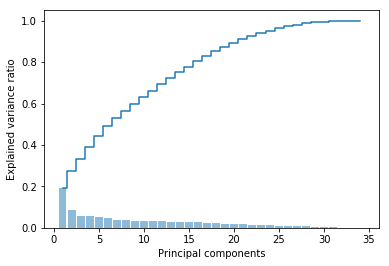

In [67]:
plt.bar(range(1, 35), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 35), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

#### Results
Looks like 15 components could explain 80% of the variance in our data. However, using the PCA transformed data does not improve performance of our classifiers (except for KNN - slightly)

In [74]:
pca = PCA(n_components = 15)

X_train_pca = pca.fit_transform(X_train_form_std)
X_test_pca = pca.transform(X_test_form_std)

for clf in clfs:
    clf.fit(X_train_pca, y_train_form)
    print(type(clf))
    print("score = ", clf.score(X_test_pca, y_test_form), "\n")

<class 'sklearn.linear_model.logistic.LogisticRegression'>
score =  0.6107456140350878 

<class 'sklearn.ensemble.forest.RandomForestClassifier'>
score =  0.5098684210526315 

<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
score =  0.581140350877193 

<class 'sklearn.neighbors.classification.KNeighborsClassifier'>
score =  0.5098684210526315 



### Feature extraction with LDA

In [91]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)

X_train_lda = lda.fit_transform(X_train_form, y_train_form)
X_test_lda = lda.transform(X_test_form)

for clf in clfs:
    clf.fit(X_train_lda, y_train_form)
    print(type(clf))
    print("score = ", clf.score(X_test_lda, y_test_form), "\n")

<class 'sklearn.linear_model.logistic.LogisticRegression'>
score =  0.6578947368421053 

<class 'sklearn.ensemble.forest.RandomForestClassifier'>
score =  0.5888157894736842 

<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
score =  0.6282894736842105 

<class 'sklearn.neighbors.classification.KNeighborsClassifier'>
score =  0.581140350877193 



#### Results
Except for KNN, which sees a great improvement (0.47 -> 0.58), using the LDA transformed data also doesn't improve performance of our classifiers very much

### Feature extraction with KPCA

In [92]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)

X_train_kpca = kpca.fit_transform(X_train_form)
X_test_kpca = kpca.transform(X_test_form)

for clf in clfs:
    clf.fit(X_train_kpca, y_train_form)
    print(type(clf))
    print("score = ", clf.score(X_test_kpca, y_test_form), "\n")

<class 'sklearn.linear_model.logistic.LogisticRegression'>
score =  0.4649122807017544 

<class 'sklearn.ensemble.forest.RandomForestClassifier'>
score =  0.31030701754385964 

<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
score =  0.4649122807017544 

<class 'sklearn.neighbors.classification.KNeighborsClassifier'>
score =  0.22478070175438597 



#### Results
Surprisingly, using KPCA transformed data decreases our classifiers performance a lot

### Ensemble Model

In [136]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier

for label, clf in zip(clf_labels, all_clf):
    scores = cross_val_score(estimator=clf, X = X_train_form, y = y_train_form, cv = 10, scoring = 'accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.64 (+/- 0.02) [Logistic Regression]
Accuracy: 0.56 (+/- 0.02) [Random Forest]
Accuracy: 0.62 (+/- 0.01) [Gradient Boosting]
Accuracy: 0.44 (+/- 0.03) [KNN]


In [137]:
#Ensemble model:
eclf = VotingClassifier(estimators=[('lr',lr), ('rf',rf), ('gb',gb), ('knn',knn)], voting='hard')

scores = cross_val_score(estimator=eclf, X=X_train_form, y = y_train_form, cv= 10, scoring = 'accuracy')

print("Accuracy: %0.2f (+/- %0.2f)"  % (scores.mean(), scores.std()))

Accuracy: 0.61 (+/- 0.02)


In [140]:
eclf.fit(X_train_form,y_train_form)

y_pred_eclf = eclf.predict(X_test_form)

print("Accuracy score = ", accuracy_score(y_pred_eclf,y_test_form))

Accuracy score =  0.6425438596491229


#### Results
Ensemble model doesn't improve the result much compare to individual classifiers

## Form Reconsidered & Expected Goals
What if we consider that goal-scoring is just part of the picture as far as recent performance is concerned. After all, there is a bit of luck included in scoring goals. Of course, this is ultimately what we're interested in, but given that we have more features that just goals scored available, perhaps we should use them. 

We'll assume that the goals scored in each game is, in some sense, a function of a team's statistical performance over a recent window. That is, our $X$ input is a concatenation of multiple games. We can, then also provide an indicator variable as to whether they are playing home/away. This, now, becomes a regression problem, where our target variable is the actual score.

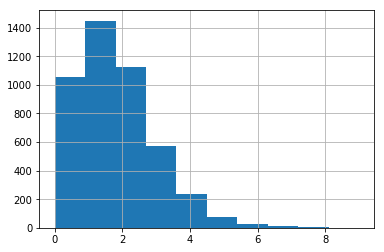

In [141]:
_ = df.Score_home.hist()

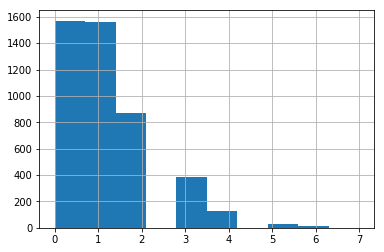

In [142]:
_ = df.Score_away.hist()

### Melted DataFrame
In order to perform this analysis, firstly we must melt out our above dataframe such that one row signifies a team's performance in an individual game. 

In [143]:
df.drop(columns = features_to_drop, inplace = True)
print(list(df))

['MatchID', 'Home_team', 'Away_team', 'Score_home', 'Score_away', 'Shots_on_target_home', 'Shots_on_target_away', 'Passes_home', 'Passes_away', 'Clearances_home', 'Clearances_away', 'Offsides_home', 'Offsides_away', 'Fouls_conceded_home', 'Fouls_conceded_away', 'year', 'Expenditures_home', 'Income_home', 'Expenditures_away', 'Income_away', 'target']


In [144]:
home_attributes = ['MatchID', 'Home_team', 'year'] + [a for a in list(df) if 'home' in a]
away_attributes = ['MatchID', 'Away_team', 'year'] + [a for a in list(df) if 'away' in a]

print(home_attributes, '\n')
print(away_attributes)

['MatchID', 'Home_team', 'year', 'Score_home', 'Shots_on_target_home', 'Passes_home', 'Clearances_home', 'Offsides_home', 'Fouls_conceded_home', 'Expenditures_home', 'Income_home'] 

['MatchID', 'Away_team', 'year', 'Score_away', 'Shots_on_target_away', 'Passes_away', 'Clearances_away', 'Offsides_away', 'Fouls_conceded_away', 'Expenditures_away', 'Income_away']


In [145]:
melted = []

for _, row in df.iterrows():
    home_team = [row[attr] for attr in away_attributes] + [1]
    away_team = [row[attr] for attr in home_attributes] + [0]
    melted.append(home_team)
    melted.append(away_team)

print(melted[0])

[5567, 'Aston Villa', 2007, 1, 3, 232, 51, 6, 19, 28.16, 2.08, 1]


In [146]:
features = ['MatchID', 'Team', 'year'] + [a.split('_')[0] for a in list(df) if 'home' in a] + ['IsHome']
print(features)

['MatchID', 'Team', 'year', 'Score', 'Shots', 'Passes', 'Clearances', 'Offsides', 'Fouls', 'Expenditures', 'Income', 'IsHome']


In [147]:
melted_df = pd.DataFrame(melted, columns = features)
melted_df.head()

,MatchID,Team,year,Score,Shots,Passes,Clearances,Offsides,Fouls,Expenditures,Income,IsHome
0,5567,Aston Villa,2007,1,3,232,51,6,19,28.16,2.08,1
1,5567,Arsenal,2007,1,7,631,14,2,10,17.10,14.85,0
2,5568,Spurs,2007,0,2,427,43,1,22,69.54,44.06,1
3,5568,Bolton,2007,2,4,243,20,3,22,19.38,4.39,0
4,5569,Watford,2007,1,7,321,32,1,15,11.97,15.39,1


Now, we can run our regression problem where our target variable is the goals scored by each team. We could also consider it a multi-class classification problem, but now we have some further flexibility.

In [148]:
from sklearn.linear_model import Lasso, Ridge, BayesianRidge, LinearRegression
regression_clfs = [LogisticRegression(), RandomForestClassifier(), 
                   Lasso(), Ridge(), BayesianRidge(), LinearRegression()]

In [149]:
scaler = StandardScaler()
# drop variables that are proxies for target
melted_df_wo = melted_df.drop(columns = ['MatchID', 'Team', 'year'])
print(list(melted_df_wo))

X = melted_df_wo.drop(columns = ['Score']).values
X_scaled = scaler.fit_transform(X)
y = melted_df['Score'].values

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = .2, random_state = 42)

['Score', 'Shots', 'Passes', 'Clearances', 'Offsides', 'Fouls', 'Expenditures', 'Income', 'IsHome']


In [150]:
# build regression model for goals within a game (omit most recent year which we'll use for simulation)
list(melted_df)

['MatchID',
 'Team',
 'year',
 'Score',
 'Shots',
 'Passes',
 'Clearances',
 'Offsides',
 'Fouls',
 'Expenditures',
 'Income',
 'IsHome']

In [151]:
from sklearn.metrics import mean_squared_error

for clf in regression_clfs:
    clf.fit(X_train, y_train)
    print(type(clf))
    y_pred = clf.predict(X_test)
    print("rmse = ", mean_squared_error(y_test, y_pred) ** .5)

<class 'sklearn.linear_model.logistic.LogisticRegression'>
rmse =  1.2210442191785065
<class 'sklearn.ensemble.forest.RandomForestClassifier'>
rmse =  1.3321214093540656
<class 'sklearn.linear_model.coordinate_descent.Lasso'>
rmse =  1.282620230552026
<class 'sklearn.linear_model.ridge.Ridge'>
rmse =  1.0336779262090081
<class 'sklearn.linear_model.bayes.BayesianRidge'>
rmse =  1.0337730287770233
<class 'sklearn.linear_model.base.LinearRegression'>
rmse =  1.033672021626754


The error here is pretty crummy, but at the very least we can perhaps try to use some linear regression methods in order to build out an expected goals model. In order to perform a season-long simulation, however, we also have to treat our game-level statistics as outputs of a function. 
### Season Simulation
Given that we've already argued previous form is an indicator of a team's performance. We'll use the game statistics dervied from the past 10 games as an input vector, along with the home/away indicator to predict the set of game-level statistics we have decided to use. Which is
```
['Shots_on_target', 'Passes', 'Clearances', 'Offsides', 'Fouls', 'Expenditures', 'Income', 'IsHome']
```

Note, in order to do this we have to construct a vector of the past 10 games for each team going into a game.

In [152]:
# we'll use the most recent year for our simulation
WINDOW = 10
max(melted_df.year)

2018

In [153]:
# which teams were in the league that year?
unique_teams = melted_df[melted_df.year == 2018].Team.unique()
unique_teams

array(['Leicester', 'Arsenal', 'Man City', 'Brighton', 'Burnley',
       'Chelsea', 'Huddersfield', 'Crystal Palace', 'Stoke', 'Everton',
       'West Ham', 'Man Utd', 'Spurs', 'Newcastle', 'Swansea',
       'Southampton', 'Liverpool', 'Watford', 'Bournemouth', 'West Brom'],
      dtype=object)

In [154]:
#expected goals model
def build_exp_goals(df, clf):
    X = df[df.year < 2018].drop(columns = ['MatchID', 'Team', 'year', 'Score']).values
    y = df[df.year < 2018].Score.values
    clf.fit(X, y)
    return clf

In [155]:
goal_model = build_exp_goals(melted_df, BayesianRidge())

In [156]:
def build_stat_model(df, clf, feature = 'Score'):
    teams = df[df.year == 2018].Team.unique()
    X_as_list, y_as_list = [], []
    for team in teams:
        team_df = df[df.Team == team]
        fit_df = team_df[team_df.year != 2018].drop(columns = ['MatchID', 'Team', 'year', feature])
        for i in range(0, team_df.shape[0] - WINDOW - 1):
            X_vec = fit_df.iloc[i:i + WINDOW].values.flatten()
            if X_vec.shape[0] == 80:  # must have ten games of 8 features
                # TODO: need to add indicator of current game isHome
                X_as_list.append(X_vec) 
                y_as_list.append(team_df[feature].values[i + WINDOW + 1])    
    
    # convert to vectors for model input
    X = np.vstack(X_as_list)
    y = np.array(y_as_list)
    clf.fit(X, y)
    return clf

In [157]:
# now we can build a model for each individual statistic
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor

model_map = {'Shots': LinearRegression(),
             'Passes': Ridge(),
             'Clearances': GradientBoostingRegressor(),
             'Offsides': Ridge(),
             'Fouls': GradientBoostingRegressor()}

for feature, clf in model_map.items():
    model_map[feature] = build_stat_model(melted_df, clf, feature)

Now we'll use these models to determine a confidence bound for each statistic of an individual game. We can let this simulation run for the entire season, thus finding one potential "path" as it were that the season could go. Then, we'll run this numerous times. Averaging the resultant tables at the end should yield something (hopefully) approximating the actual league table. 

In [158]:
# now for each game in 2018 we have to simulate the match statistics & the resultant expected goals
# recall we're using 10 games of history 
# so we'll start with the 2017 games and append each game in 2018 one-by-one
simulated_df = melted_df[melted_df.year == 2017]
simulated_df.head()
print(simulated_df.Team.unique())

['Liverpool' 'Arsenal' 'Man Utd' 'Bournemouth' 'Swansea' 'Burnley'
 'West Ham' 'Chelsea' 'West Brom' 'Crystal Palace' 'Spurs' 'Everton'
 'Leicester' 'Hull' 'Sunderland' 'Man City' 'Stoke' 'Middlesbrough'
 'Watford' 'Southampton']


In [159]:
st_dev_map = { feature: np.std(melted_df[feature]) for feature in model_map.keys()}
# np.std(melted_df['Shots'])
print(st_dev_map)

{'Shots': 2.546931901038951, 'Passes': 115.36831591439368, 'Clearances': 14.842825213227503, 'Offsides': 1.8304938875131618, 'Fouls': 3.8904622989576176}


In [160]:
import random

def fit_game(game, df, clf_map, goal_model):
    # there is one caveat here, given relegation we need to proxy the newly promoted teams
    # of ['Brighton', 'Huddersfield', 'Newcastle']
    # with ones relegated in 2017 => ['Hull', 'Middlesbrough', 'Sunderland']
    relegated = ['Hull', 'Middlesbrough', 'Sunderland']

    # find team's previous results pull out last 10 games and vectorize
    team_df = df[df.Team == game.Team]
    if team_df.shape[0] < 10: # newly promoted team at beginning of simulation
        relegated_df = df[(df.Team == relegated[0]) | (df.Team == relegated[1]) | (df.Team == relegated[2])]
        team_df = pd.concat([relegated_df, team_df])
    
    new_row = {'MatchID': game.MatchID, 'Team': game.Team, 'year': game.year, 'Score': None, 'Shots': None, 
               'Passes': None, 'Clearances': None, 'Offsides': None, 'Fouls': None,
               'Expenditures': game.Expenditures, 'Income': game.Income, 'IsHome': game.IsHome}
    
    for feature in clf_map.keys():
        X = team_df.tail(WINDOW).drop(columns = ['MatchID', 'Team', 'year', feature]).values.flatten().reshape(1,-1)
        # add randomness feature (i.e. sample from the confidence interval)
        random_noise = st_dev_map[feature] * np.random.normal()
        new_row[feature] = max(int(clf_map[feature].predict(X)[0] + random_noise), 0)

    goal_features = ['Shots', 'Passes', 'Clearances', 'Offsides', 'Fouls', 'Expenditures', 'Income', 'IsHome']
    X_score_as_list = [ new_row[feature] for feature in goal_features ]
    
    # calculate expected goals
    X_score = np.array(X_score_as_list).reshape(1, -1)
    new_row['Score'] = int(goal_model.predict(X_score)[0])
    return new_row

In [161]:
season_df = melted_df[melted_df.year == 2018].drop(columns = list(model_map.keys()) + ['Score'])
season_df.head()

,MatchID,Team,year,Expenditures,Income,IsHome
8352,22342,Leicester,2018,100.14,54.61,1
8353,22342,Arsenal,2018,174.25,178.07,0
8354,22343,Man City,2018,361.95,104.14,1
8355,22343,Brighton,2018,72.39,0.00,0
8356,22344,Burnley,2018,40.74,57.00,1


In [162]:
# now we'll use this dataframe to generate all the results
for row in season_df.iterrows():
    game = row[1]
    simulated_result = fit_game(game, simulated_df, model_map, goal_model)
    simulated_df = simulated_df.append(simulated_result, ignore_index = True)
    
print(simulated_df.tail())

      MatchID       Team  year  Score  Shots  Passes  Clearances  Offsides  \
1513    22719    Swansea  2018      1      6     262          36         1   
1514    22720  Leicester  2018      2      8     389          30         0   
1515    22720      Spurs  2018      2      7     586          23         0   
1516    22721    Everton  2018      1      6     494           9         0   
1517    22721   West Ham  2018      0      3     340           6         0   

      Fouls  Expenditures  Income  IsHome  
1513     10         83.66   92.45       0  
1514     17        100.14   54.61       1  
1515      8        138.51  118.33       0  
1516     10        231.65  144.19       1  
1517     20         64.75   78.69       0  


In [163]:
def get_team_points(df):
    year_df = df[df.year == 2018]
    point_dict = { team: [] for team in year_df.Team.unique() } 
    match_ids = year_df.MatchID.unique()
    for match_id in match_ids:
        game = year_df[year_df.MatchID == match_id]
        result = game[['Team', 'Score']].values
        if result[0][1] == result[1][1]:
            point_dict[result[0][0]].append(1)
            point_dict[result[1][0]].append(1)
        elif result[0][1] > result[1][1]:
            point_dict[result[0][0]].append(3)
            point_dict[result[1][0]].append(0)            
        else:
            point_dict[result[0][0]].append(0)
            point_dict[result[1][0]].append(3)
            
    table = []
    for team, point_list in point_dict.items():
        table.append( (team, sum(point_list)) )
    return table

In [164]:
points = get_team_points(simulated_df)
sorted( points, key = lambda x: -x[1])

[('Man City', 76),
 ('Chelsea', 74),
 ('Everton', 72),
 ('Spurs', 69),
 ('Arsenal', 64),
 ('Liverpool', 63),
 ('Newcastle', 56),
 ('Leicester', 53),
 ('Swansea', 52),
 ('Man Utd', 49),
 ('West Brom', 47),
 ('Crystal Palace', 41),
 ('Stoke', 41),
 ('Southampton', 41),
 ('Brighton', 40),
 ('Bournemouth', 40),
 ('West Ham', 37),
 ('Huddersfield', 36),
 ('Watford', 35),
 ('Burnley', 26)]

In [165]:
def run_simulations(df, runs, model_map, goal_model):
    season_df = df[df.year == 2018].drop(columns = list(model_map.keys()) + ['Score'])
    base_df = df[df.year == 2017]
    season_point_totals = { team: [] for team in season_df.Team.unique() } # list of simulation results
    
    for run in range(runs):
        
        # reset simulation_df
        run_df = base_df.copy()
    
        # run_simulation
        for row in season_df.iterrows():
            game = row[1]
            simulated_result = fit_game(game, run_df, model_map, goal_model)
            run_df = run_df.append(simulated_result, ignore_index = True)
    
        # add season result to simulation results
        simulated_table = get_team_points(run_df)
        for points in simulated_table:
            season_point_totals[points[0]].append(points[1])
        
    return [ (team, sum(point_totals)/len(point_totals)) for team, point_totals in season_point_totals.items() ]

In [166]:
RUNS = 20

avg_table = run_simulations(melted_df, RUNS, model_map, goal_model)

sorted(avg_table, key = lambda x: -x[1])

[('Man City', 82.75),
 ('Chelsea', 78.5),
 ('Liverpool', 63.95),
 ('Everton', 63.8),
 ('Arsenal', 63.05),
 ('Spurs', 62.3),
 ('Man Utd', 59.85),
 ('Swansea', 46.75),
 ('Southampton', 45.05),
 ('Burnley', 43.65),
 ('Bournemouth', 43.35),
 ('Watford', 42.9),
 ('Leicester', 42.85),
 ('West Ham', 41.45),
 ('Stoke', 39.8),
 ('Crystal Palace', 37.55),
 ('Brighton', 37.2),
 ('Huddersfield', 36.75),
 ('Newcastle', 36.0),
 ('West Brom', 35.45)]